<a href="https://colab.research.google.com/github/keshav-192/Machine_Learning_Model_for_Electoral_Predictions_Using_Twitter_Data/blob/main/Machine_Learning_Model_for_Electoral_Predictions_Using_Twitter_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ---- MODULE 1: Drive Mount & Data Load ----

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# DATA PATH — update if needed
DATA_PATH = '/content/drive/MyDrive/IndianElection19TwitterData.csv'

# Load dataset
df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
print(df.head())

# Check columns
print("Columns:", df.columns.tolist())

Mounted at /content/drive
Shape: (142566, 4)
   Unnamed: 0                       Date             User  \
0           0  2019-05-18 23:50:47+00:00  advosushildixit   
1           1  2019-05-18 23:20:00+00:00    airnewsalerts   
2           2  2019-05-18 23:00:03+00:00           jiaeur   
3           3  2019-05-18 22:53:54+00:00    PVenkatGandhi   
4           4  2019-05-18 22:20:48+00:00      TheNirbhay1   

                                               Tweet  
0  @anjanaomkashyap I am seeing you as future #bj...  
1  Trinamool Congress Sitting MP Abhishek Banerje...  
2  #LokSabhaElections2019 \n23rd May 2019 will re...  
3  #LokSabhaElections2019 \n23rd May 2019 will re...  
4  PM Modi creates a new record of being the only...  
Columns: ['Unnamed: 0', 'Date', 'User', 'Tweet']


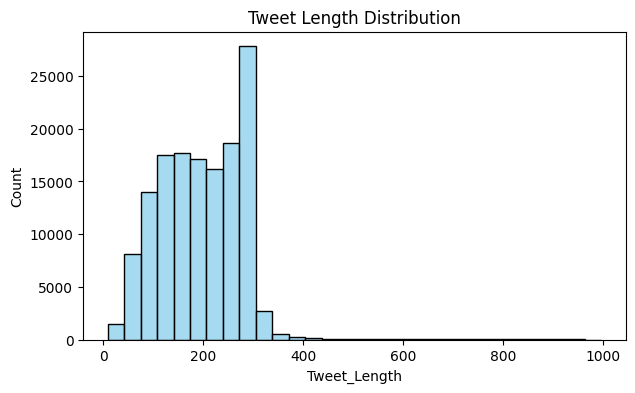

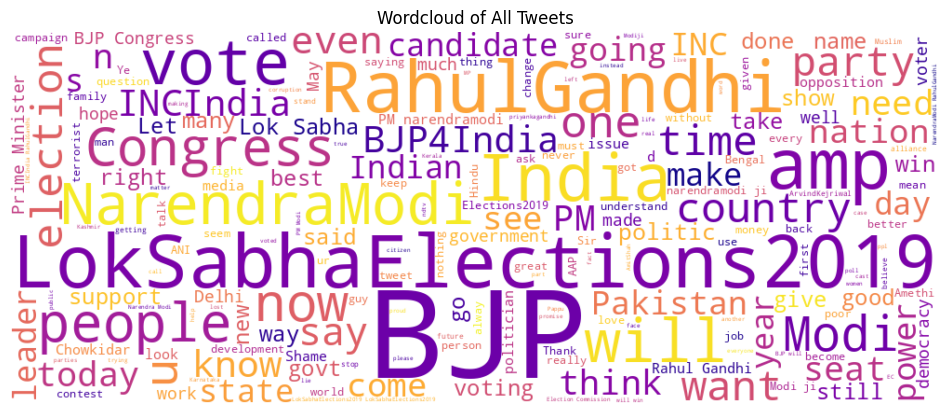

In [3]:
# ---- MODULE 2: Data Cleaning & EDA ----

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Drop duplicates & missing
df.drop_duplicates(inplace=True)
df.dropna(subset=['Tweet'], inplace=True)

# EDA - Tweet length
df['Tweet_Length'] = df['Tweet'].apply(len)
plt.figure(figsize=(7,4))
sns.histplot(df['Tweet_Length'], bins=30, color='skyblue')
plt.title('Tweet Length Distribution')
plt.show()

# Wordcloud - all tweets
text = ' '.join(df['Tweet'])
wc = WordCloud(width=1000, height=400, background_color='white', colormap='plasma').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of All Tweets')
plt.show()

# Save cleaned version for next modules
df.to_csv('/content/cleaned_tweets.csv', index=False)


Party
BJP         91448
Others      42920
Congress     6872
AAP          1326
Name: count, dtype: int64


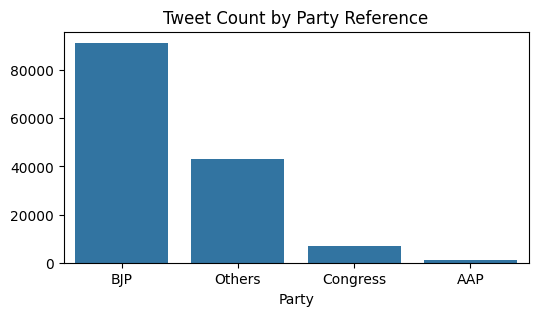

In [4]:
# ---- MODULE 3: Party Label Extraction ----

# Example: Simple party mapping by keywords in tweet (customize as needed!)
# Add other parties as needed
party_keywords = {
    'BJP': ['bjp', 'modi', 'narendra modi', 'lotus', '#bjp', 'amit shah'],
    'Congress': ['congress', 'rahul gandhi', '#congress', 'sonia gandhi'],
    'AAP': ['aap', 'kejriwal', '#aap'],
    'Others': []
}

def extract_party(tweet):
    tweet_low = tweet.lower()
    for party, keywords in party_keywords.items():
        if any(kw in tweet_low for kw in keywords):
            return party
    return 'Others'

df = pd.read_csv('/content/cleaned_tweets.csv')
df['Party'] = df['Tweet'].apply(extract_party)

print(df['Party'].value_counts())

plt.figure(figsize=(6,3))
sns.barplot(x=df['Party'].value_counts().index, y=df['Party'].value_counts().values)
plt.title('Tweet Count by Party Reference')
plt.show()

# Save for next modules
df.to_csv('/content/tweets_with_party.csv', index=False)


/tmp/ipython-input-1886769358.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Sentiment_Class'], palette='RdYlGn')


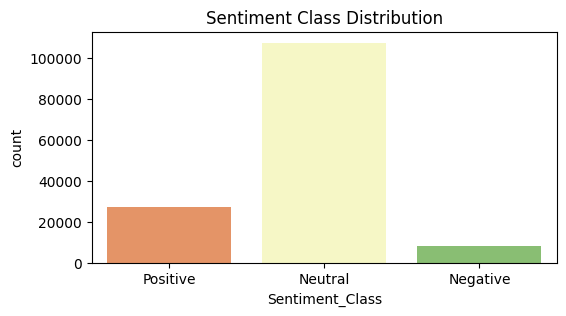

/tmp/ipython-input-1886769358.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Party', y='Sentiment_Polarity', data=df, palette='Set2')


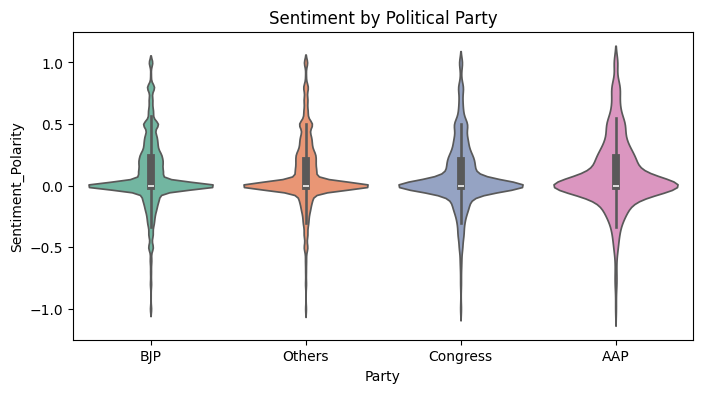

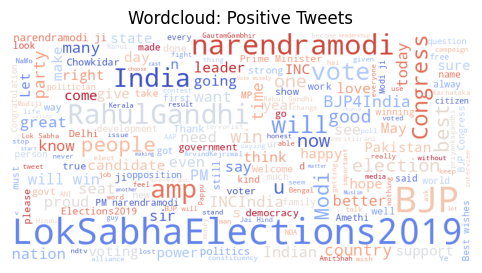

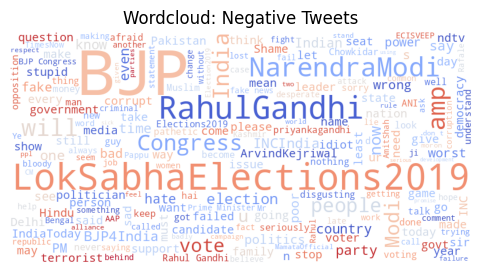

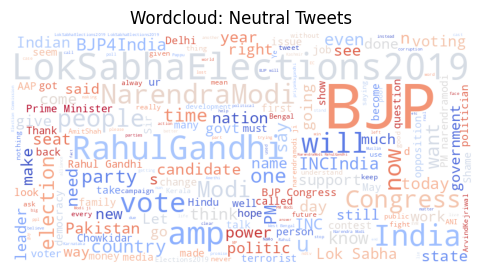

In [5]:
# ---- MODULE 4: Sentiment Features ----

from textblob import TextBlob

# Optionally install if not available on Colab
# !pip install textblob --quiet

df = pd.read_csv('/content/tweets_with_party.csv')

# Polarity, subjectivity
df['Sentiment_Polarity'] = df['Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment_Subjectivity'] = df['Tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Sentiment class label
def sentiment_label(score):
    if score >= 0.3:
        return 'Positive'
    elif score <= -0.3:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Class'] = df['Sentiment_Polarity'].apply(sentiment_label)

# Distribution plot by sentiment
plt.figure(figsize=(6,3))
sns.countplot(x=df['Sentiment_Class'], palette='RdYlGn')
plt.title('Sentiment Class Distribution')
plt.show()

# Party-wise sentiment
plt.figure(figsize=(8,4))
sns.violinplot(x='Party', y='Sentiment_Polarity', data=df, palette='Set2')
plt.title('Sentiment by Political Party')
plt.show()

# Wordclouds by sentiment
for sentiment in ['Positive','Negative','Neutral']:
    subset = df[df['Sentiment_Class']==sentiment]
    text = ' '.join(subset['Tweet'].tolist())
    wc = WordCloud(width=800, height=400, background_color='white',colormap='coolwarm').generate(text)
    plt.figure(figsize=(8,3))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f'Wordcloud: {sentiment} Tweets')
    plt.show()

df.to_csv('/content/tweets_with_sentiment.csv', index=False)


In [6]:
# ---- MODULE 5: Text Preprocessing & Vectorizer ----

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('/content/tweets_with_sentiment.csv')

# Preprocessing (basic lower, remove special chars, etc)
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+|#', '', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text
df['Clean_Tweet'] = df['Tweet'].apply(clean_text)

# Vectorization: Using TF-IDF (other options: embeddings etc.)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Clean_Tweet']).toarray()

print("TF-IDF shape:", X.shape)

# Model target: Predict Party (classification)
y = df['Party']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


TF-IDF shape: (142566, 5000)
Train shape: (128309, 5000) Test shape: (14257, 5000)


In [7]:
# ---- MODULE 6: Stacking Ensemble with SVC ----

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import pandas as pd

# Load data
df = pd.read_csv('/content/tweets_with_sentiment.csv')

# Sample for RAM safety
if df.shape[0] > 15000:
    df = df.sample(45000, random_state=42)

# Minimal clean text
if 'Clean_Tweet' not in df.columns:
    def clean_text(text):
        import re
        text = str(text)
        text = text.lower()
        text = re.sub(r'[^a-z ]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    df['Clean_Tweet'] = df['Tweet'].map(clean_text)

# TF-IDF (balanced feature count)
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['Clean_Tweet'])
y = df['Party']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# 7 base models, adding SVC
base_models = [
    ('rf', RandomForestClassifier(n_estimators=120, random_state=42, n_jobs=1)),
    ('et', ExtraTreesClassifier(n_estimators=120, random_state=43, n_jobs=1)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=44)),
    ('nb', MultinomialNB()),
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier(max_depth=7, random_state=45)),
    ('svc', LinearSVC(max_iter=1000, random_state=46))
]

# Meta learner (should support multiclass!)
meta_model = LogisticRegression(max_iter=2000)

stack = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=1
)

# Train stacking
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

from sklearn.metrics import accuracy_score
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Stacking Model Accuracy: 0.9741


In [8]:
# ---- MODULE 7: Individual Base Model & Stacking (Meta) Model Reports ----

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Base models list (same order as before)
base_models = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=1)),
    ('et', ExtraTreesClassifier(n_estimators=50, random_state=43, n_jobs=1)),
    ('gb', GradientBoostingClassifier(n_estimators=25, random_state=44)),
    ('nb', MultinomialNB()),
    ('lr', LogisticRegression(max_iter=200)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=45)),
]

print("BASE MODELS CLASSIFICATION REPORT:")
base_reports = {}

for name, model in base_models:
    # Fit the model
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred_model = model.predict(X_test)
    # Accuracy + report
    acc = accuracy_score(y_test, y_pred_model)
    print(f"\n{name} | Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred_model))
    base_reports[name] = (acc, classification_report(y_test, y_pred_model, output_dict=True))
    # Optional: Confusion Matrix Plot


print("\nSTACKING META MODEL CLASSIFICATION REPORT:")
stack_meta_acc = accuracy_score(y_test, y_pred)
print(f"Meta Model (Stacking output) | Accuracy: {stack_meta_acc:.4f}")
print(classification_report(y_test, y_pred))



BASE MODELS CLASSIFICATION REPORT:

rf | Accuracy: 0.9644
              precision    recall  f1-score   support

         AAP       0.88      0.72      0.79        60
         BJP       0.99      0.97      0.98      4337
    Congress       0.92      0.82      0.87       324
      Others       0.92      0.99      0.95      2029

    accuracy                           0.96      6750
   macro avg       0.93      0.87      0.90      6750
weighted avg       0.97      0.96      0.96      6750


et | Accuracy: 0.9370
              precision    recall  f1-score   support

         AAP       0.93      0.47      0.62        60
         BJP       0.94      0.97      0.96      4337
    Congress       0.95      0.56      0.70       324
      Others       0.92      0.94      0.93      2029

    accuracy                           0.94      6750
   macro avg       0.94      0.73      0.80      6750
weighted avg       0.94      0.94      0.93      6750


gb | Accuracy: 0.9547
              precision   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


lr | Accuracy: 0.9559
              precision    recall  f1-score   support

         AAP       0.93      0.45      0.61        60
         BJP       0.99      0.96      0.97      4337
    Congress       0.92      0.73      0.82       324
      Others       0.90      0.99      0.94      2029

    accuracy                           0.96      6750
   macro avg       0.94      0.78      0.84      6750
weighted avg       0.96      0.96      0.95      6750


dt | Accuracy: 0.9401
              precision    recall  f1-score   support

         AAP       0.00      0.00      0.00        60
         BJP       1.00      0.94      0.97      4337
    Congress       0.90      0.73      0.80       324
      Others       0.84      1.00      0.91      2029

    accuracy                           0.94      6750
   macro avg       0.69      0.67      0.67      6750
weighted avg       0.94      0.94      0.94      6750


STACKING META MODEL CLASSIFICATION REPORT:
Meta Model (Stacking output) | Accuracy:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

              precision    recall  f1-score   support

         AAP       0.91      0.88      0.90        60
         BJP       1.00      0.97      0.99      4337
    Congress       0.95      0.88      0.91       324
      Others       0.93      1.00      0.96      2029

    accuracy                           0.97      6750
   macro avg       0.95      0.93      0.94      6750
weighted avg       0.98      0.97      0.97      6750



Evaluating: RandomForest
RandomForest accuracy: 0.9673


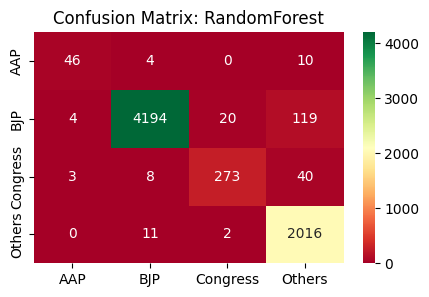

Evaluating: ExtraTrees
ExtraTrees accuracy: 0.9401


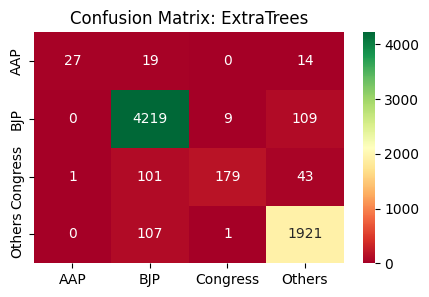

Evaluating: GradientBoost
GradientBoost accuracy: 0.9607


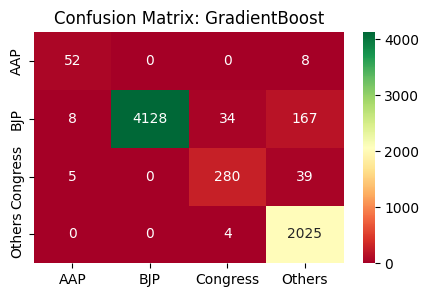

Evaluating: MultinomialNB
MultinomialNB accuracy: 0.7345


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


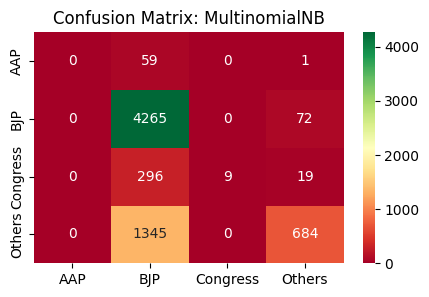

Evaluating: LogReg
LogReg accuracy: 0.9559


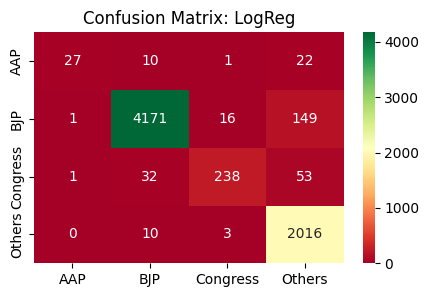

Evaluating: DecisionTree
DecisionTree accuracy: 0.9480


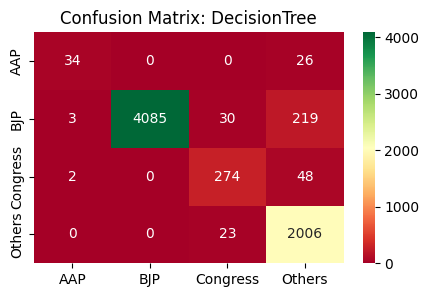

Evaluating: LinearSVC
LinearSVC accuracy: 0.9695


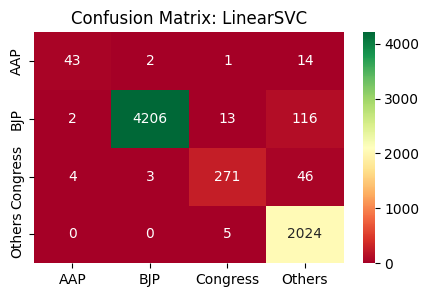

Stacking Meta Model Accuracy: 0.9741


/tmp/ipython-input-1588224551.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='Blues')


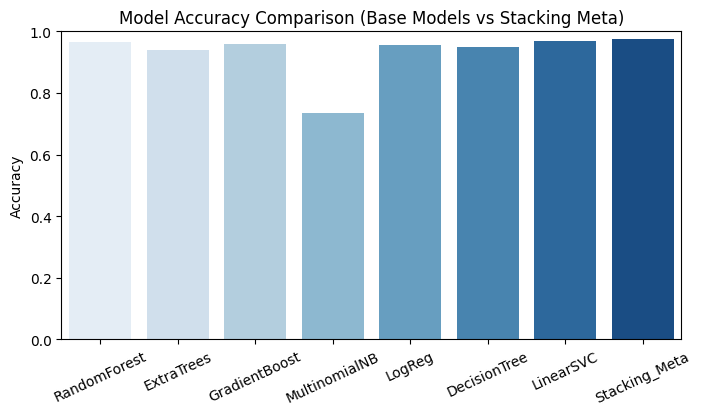

In [9]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# List of all base models (use those which were in stacking)
base_models_eval = [
    ('RandomForest', RandomForestClassifier(n_estimators=120, random_state=42, n_jobs=1)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=120, random_state=43, n_jobs=1)),
    ('GradientBoost', GradientBoostingClassifier(n_estimators=50, random_state=44)),
    ('MultinomialNB', MultinomialNB()),
    ('LogReg', LogisticRegression(max_iter=1000)),
    ('DecisionTree', DecisionTreeClassifier(max_depth=7, random_state=45)),
    ('LinearSVC', LinearSVC(max_iter=1000, random_state=46))
]

accuracies = {}
reports = {}

for name, mdl in base_models_eval:
    print(f"Evaluating: {name}")
    mdl.fit(X_train, y_train)
    yb_pred = mdl.predict(X_test)
    acc = accuracy_score(y_test, yb_pred)
    accuracies[name] = acc
    reports[name] = classification_report(y_test, yb_pred, output_dict=True)
    print(f"{name} accuracy: {acc:.4f}")
    # Optional: plot confusion matrix for each base model
    cm = confusion_matrix(y_test, yb_pred, labels=np.unique(y))
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

# Add stacking meta-model accuracy
meta_acc = accuracy_score(y_test, y_pred)
accuracies['Stacking_Meta'] = meta_acc
print(f"Stacking Meta Model Accuracy: {meta_acc:.4f}")

# Barplot: Model accuracy comparison
plt.figure(figsize=(8,4))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='Blues')
plt.title("Model Accuracy Comparison (Base Models vs Stacking Meta)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=25)
plt.show()


✔️ Final predictions saved with test data!


/tmp/ipython-input-3843746013.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_counts.index, y=pred_counts.values, palette='Set2')


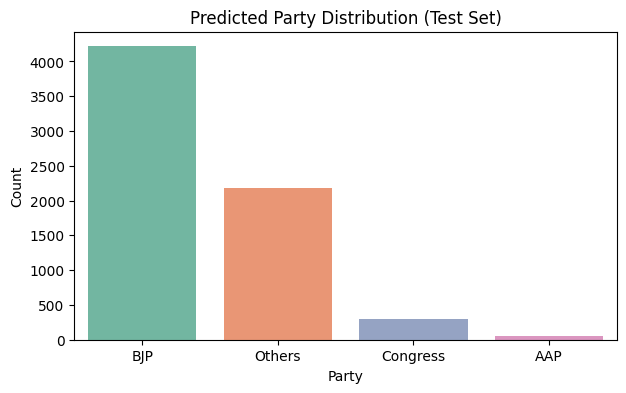

/tmp/ipython-input-3843746013.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_probs.index, y=avg_probs.values, palette='Blues')


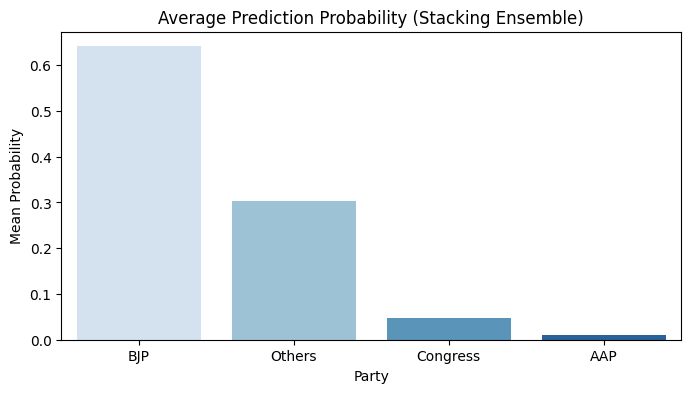

Predicted Winning Party (highest average probability): BJP
All party probabilities:
 BJP         0.641274
Others      0.302342
Congress    0.046972
AAP         0.009411
dtype: float64


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume: df, y_test, y_pred, stack, X_test already defined, and index of df reset hai!

# [1] Save final predictions alongside ground truth for analysis
df_test = df.loc[y_test.index].copy()              # Use .loc with y_test.index
df_test['Stacking_Prediction'] = y_pred
df_test.to_csv('/content/Final_Election_Predictions.csv', index=False)
print("✔️ Final predictions saved with test data!")

# [2] Predicted party distribution (counts)
pred_counts = pd.Series(y_pred).value_counts()
plt.figure(figsize=(7,4))
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette='Set2')
plt.title("Predicted Party Distribution (Test Set)")
plt.ylabel("Count")
plt.xlabel("Party")
plt.show()

# [3] If probabilities available: Show average party probabilities (confidence)
proba_succeed = False
try:
    y_pred_proba = stack.predict_proba(X_test)
    proba_succeed = True
except Exception:
    print("Warning: predict_proba not available, will show prediction counts instead.")

if proba_succeed:
    avg_probs = pd.DataFrame(y_pred_proba, columns=stack.classes_).mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=avg_probs.index, y=avg_probs.values, palette='Blues')
    plt.title("Average Prediction Probability (Stacking Ensemble)")
    plt.ylabel("Mean Probability")
    plt.xlabel("Party")
    plt.show()
    print("Predicted Winning Party (highest average probability):", avg_probs.idxmax())
    print("All party probabilities:\n", avg_probs)
else:
    print("Predicted Winning Party (most counts):", pred_counts.idxmax())
    print("All party prediction counts:\n", pred_counts)


/tmp/ipython-input-3489786288.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  timeline = df_test['Date'].dt.to_period('W').value_counts().sort_index()


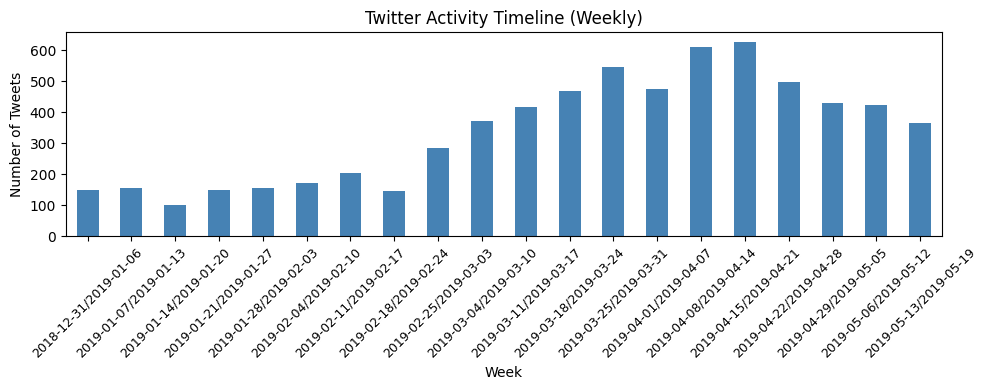

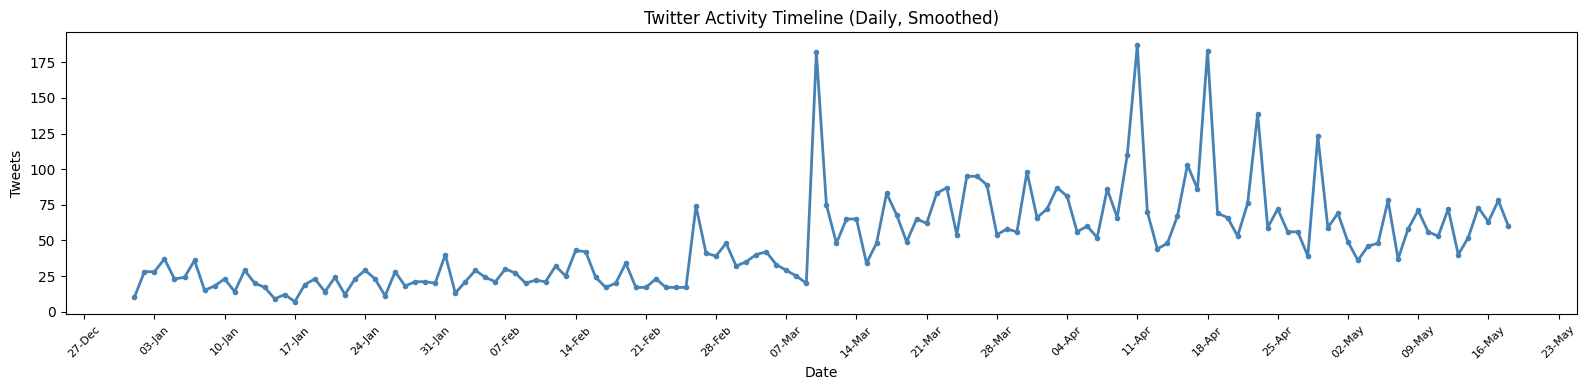

In [11]:
import matplotlib.dates as mdates

if 'Date' in df_test.columns:
    try:
        df_test['Date'] = pd.to_datetime(df_test['Date'], errors='coerce')
        # Remove NaT values
        df_test = df_test.dropna(subset=['Date'])

        # Aggregated by week (or change 'W' to '3D' for 3-day window)
        timeline = df_test['Date'].dt.to_period('W').value_counts().sort_index()
        # Or use 3-day window: '3D'

        plt.figure(figsize=(10,4))
        timeline.plot(kind='bar', color='steelblue')
        plt.title('Twitter Activity Timeline (Weekly)')
        plt.ylabel('Number of Tweets')
        plt.xlabel('Week')
        plt.xticks(rotation=45, fontsize=9)
        plt.tight_layout()
        plt.show()

        # If you still want daily but cleaner:
        date_counts = df_test['Date'].dt.date.value_counts().sort_index()
        plt.figure(figsize=(16,4))
        plt.plot(date_counts.index, date_counts.values, color='steelblue', marker='o', linewidth=2, markersize=3)
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        plt.title('Twitter Activity Timeline (Daily, Smoothed)')
        plt.ylabel('Tweets')
        plt.xlabel('Date')
        plt.xticks(rotation=45, fontsize=8)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Timeline plot error:", e)


In [12]:
from sklearn.metrics import accuracy_score

print("\n----- FINAL TRAINING OUTPUT SUMMARY -----")
print(f"Stacking Meta Model Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

if proba_succeed:
    print(f"Predicted Winner by Probability: {avg_probs.idxmax()}")
else:
    print(f"Predicted Winner by Majority Count: {pred_counts.idxmax()}")



----- FINAL TRAINING OUTPUT SUMMARY -----
Stacking Meta Model Test Accuracy: 0.9741
Predicted Winner by Probability: BJP
